In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.chdir("..")

# import sys
# sys.path.append("./vrevals")

In [1]:
import re
import json
import numpy as np
import pandas as pd
import yaml
import time
import glob

import matplotlib.pyplot as plt

In [3]:
from collections import Counter
from utils.math_equivalence import is_equiv
from utils.pass_k_utils import estimate_pass_at_k

In [4]:
def extract_math_answer(output, mode='gen'):
    if "</think>" in output:
        output = output.split("</think>")[1]
    extracted_text = ''
    # Existing extraction logic for 'gen' and 'choose' modes
    pattern = r'\\boxed\{(.*)\}'
    matches = re.findall(pattern, output)
    if matches:
        extracted_text = matches[-1]  # Take the last match
        if mode in ['choose', 'qa']:
            # Handle 'choose' mode
            inner_pattern = r'\\text\{(.*)\}'
            inner_matches = re.findall(inner_pattern, extracted_text)
            if inner_matches:
                extracted_text = inner_matches[-1]  # Take the last match
            extracted_text = extracted_text.strip("()")
    return extracted_text

def normalize_answer(text):
    text = text.lower()
    text = " ".join(text.strip().split())
    return text

def evaluate_predictions(pred_answer, labeled_answer):
    final_metric = {"is_valid_answer": False, "acc": 0, "em": 0, "f1": 0, 'math_equal': 0}
    if pred_answer != '':
        final_metric["is_valid_answer"] = True

    normalized_pred_answer = normalize_answer(pred_answer)
    normalized_ground_truth = normalize_answer(labeled_answer)

    em = int(normalized_pred_answer == normalized_ground_truth)
    acc = int(normalized_ground_truth in normalized_pred_answer)

    prediction_tokens = normalized_pred_answer.split()
    ground_truth_tokens = normalized_ground_truth.split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        f1 = 0
    else:
        precision = 1.0 * num_same / len(prediction_tokens) if len(prediction_tokens) > 0 else 0
        recall = 1.0 * num_same / len(ground_truth_tokens) if len(ground_truth_tokens) > 0 else 0
        if (precision + recall) == 0:
            f1 = 0
        else:
            f1 = (2 * precision * recall) / (precision + recall)

    final_metric["em"] = em
    final_metric["acc"] = acc
    final_metric["f1"] = f1

    final_metric["math_equal"] = is_equiv(normalized_pred_answer, normalized_ground_truth)

    # print(em, acc, f1, normalized_pred_answer, '|', normalized_ground_truth)
    return final_metric

In [5]:
class Args:
    dataset_name = "math500"
    # dataset_name = "gsm8k"
    split = "test"
    k_list = [1,4,8,32]
    subset_num = None
    step_by_step_prompt = True
    n_threads = 1
args = Args()


# job_dir = f"runs/default/{args.dataset_name}.qwen-1.5b-inst"
# job_dir = f"runs/default/{args.dataset_name}.qwen-math-1.5b-inst"
# job_dir = f"runs/default/{args.dataset_name}.gemma-3-1b-it"
job_dir = f"runs/default/{args.dataset_name}.llama-3.1-8b-inst"


# sampler_config_dir = f'{job_dir}/distilled-50.direct/sample_*'
# sampler_config_dir = f'{job_dir}/distilled-50.direct/sample_1'
# sampler_config_dir = f'{job_dir}/distilled-50.direct/sample_4'

# sampler_config_dir = f'{job_dir}/distilled-20.direct/sample_1'
# sampler_config_dir = f'{job_dir}/distilled-100.direct/sample_1'
# sampler_config_dir = f'{job_dir}/distilled-150.direct/sample_1'
# sampler_config_dir = f'{job_dir}/distilled-150.direct/sample_2'
# sampler_config_dir = f'{job_dir}/distilled-150.prefix/ThinkTo'



# sampler_config_dir = f'{job_dir}/distilled-50.direct/sample_2'
# sampler_config_dir = f'{job_dir}/direct/sample_*'
# sampler_config_dir = f'{job_dir}/direct/sample_2'
sampler_config_dir = f'{job_dir}/direct/sample_1'
# sampler_config_dir = f'{job_dir}/direct/sample_3_temp1'

prompt_csv_path = f'{job_dir}/{args.split}.prompts.csv'

# with open(f"{sampler_config_dir}/sampler_config.yaml", "r") as f:
#     sampler_config = yaml.safe_load(f)
# sampler_config

In [6]:
all_generation_csv = glob.glob(f"{sampler_config_dir}/generations.*.csv")
all_generation_df = [pd.read_csv(p) for p in all_generation_csv]
# Concatenate all dataframes in all_generation_df into a single dataframe
generation_df = pd.concat(all_generation_df, ignore_index=True)
generation_df['pred_answer'] = generation_df.response.apply(extract_math_answer)
metrics = generation_df.apply(lambda x: evaluate_predictions(str(x['pred_answer']), str(x['gt_answer'])), axis=1)
generation_df['is_correct'] = [e['math_equal'] for e in metrics]
generation_df['is_valid'] = [e['is_valid_answer'] for e in metrics]

In [7]:
generation_df

,question_id,prompt_id,response,pred_answer,gt_answer,sampler_config,is_correct,is_valid
0,0,0,"To convert the point $(0,3)$ from rectangular ...","(3, \frac{\pi}{2})","\left( 3, \frac{\pi}{2} \right)",{'tokenizer': {'pretrained_model_name_or_path'...,True,True
1,0,0,"To convert the point $(0,3)$ from rectangular ...","(3,\frac{\pi}{2})","\left( 3, \frac{\pi}{2} \right)",{'tokenizer': {'pretrained_model_name_or_path'...,True,True
2,0,0,"To convert the point $(0,3)$ from rectangular ...","(3, \frac{\pi}{2})","\left( 3, \frac{\pi}{2} \right)",{'tokenizer': {'pretrained_model_name_or_path'...,True,True
3,0,0,To convert the point from rectangular coordina...,"\left(3, \frac{\pi}{2}\right)","\left( 3, \frac{\pi}{2} \right)",{'tokenizer': {'pretrained_model_name_or_path'...,True,True
4,1,1,## Step 1: To find a way to express $\sum_{j ...,,p - q,{'tokenizer': {'pretrained_model_name_or_path'...,False,False
...,...,...,...,...,...,...,...,...
5995,498,498,"To find the value of $(a_9)^9$, we first need ...",,-1,{'tokenizer': {'pretrained_model_name_or_path'...,False,False
5996,499,499,"To find the measure of angle AHB, we can use t...",106,106^\circ,{'tokenizer': {'pretrained_model_name_or_path'...,True,True
5997,499,499,"Step 1: To find the measure of angle AHB, we ...",106,106^\circ,{'tokenizer': {'pretrained_model_name_or_path'...,True,True
5998,499,499,"Step 1: To find the measure of angle AHB, we ...",36,106^\circ,{'tokenizer': {'pretrained_model_name_or_path'...,False,True


In [8]:
grouped_df = generation_df.groupby(['question_id', 'prompt_id'])

valid_grouped = grouped_df.is_valid.apply(list).reset_index(name='valids')
valid_grouped['num_samples'] = valid_grouped.valids.apply(len)
valid_grouped['num_math_equal'] = valid_grouped.valids.apply(sum)

min_num_samples = valid_grouped['num_samples'].min()
k_list = range(1, 100)
detail_pass_at_k = {
    f"pass@{k}": estimate_pass_at_k(valid_grouped['num_samples'].values, 
                                    valid_grouped['num_math_equal'].values, k)
    for k in k_list
    if (min_num_samples >= k).all()
}
pass_at_k = {k: detail_pass_at_k[k].mean() for k in detail_pass_at_k}
pass_at_k

{'pass@1': np.float64(0.5591666666666667),
 'pass@2': np.float64(0.6683939393939394),
 'pass@3': np.float64(0.7186363636363636),
 'pass@4': np.float64(0.7490828282828282),
 'pass@5': np.float64(0.7704823232323232),
 'pass@6': np.float64(0.7868290043290043),
 'pass@7': np.float64(0.7999141414141413),
 'pass@8': np.float64(0.8106949494949495),
 'pass@9': np.float64(0.8197545454545454),
 'pass@10': np.float64(0.8274848484848485),
 'pass@11': np.float64(0.8341666666666667),
 'pass@12': np.float64(0.84)}

In [9]:
# responses = grouped_df.response.apply(list).reset_index(name='text')
pred_answers = grouped_df.pred_answer.apply(list).reset_index(name='text')
# Count the number of unique values in pred_answers for each question
pred_answers['fraction_unique_pred_answers'] = pred_answers['text'].apply(lambda x: len(set(x)) / len(x))

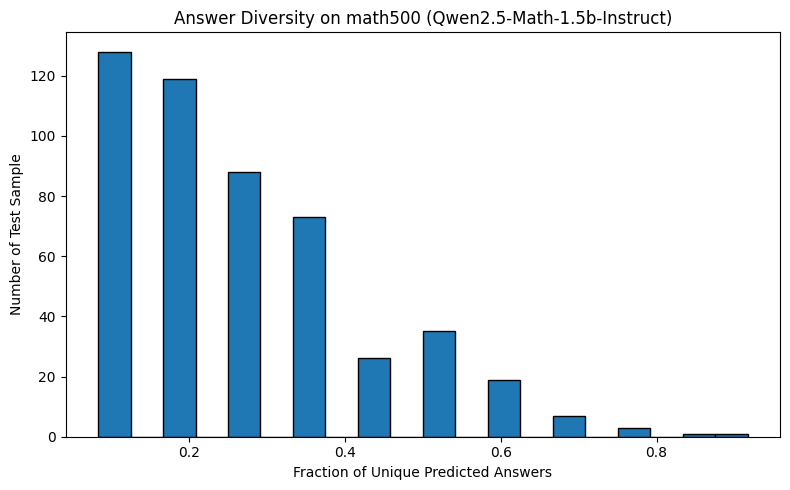

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(pred_answers['fraction_unique_pred_answers'], bins=20, edgecolor='black')
plt.xlabel('Fraction of Unique Predicted Answers')
plt.ylabel('Number of Test Sample')
plt.title(f'Answer Diversity on {args.dataset_name} (Qwen2.5-Math-1.5b-Instruct)')
plt.tight_layout()
plt.show()